In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# The tensorflow.keras.preprocessing library contains classes that
# simplify basic data collection and processing.
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
datagen = image.ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2,
    dtype="float32"
)

# imort training data
train = datagen.flow_from_directory(
    "../../leabra",
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="training"
)

# import testing data
test = datagen.flow_from_directory(
    "../../leabra",
    target_size=(100, 100),
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    batch_size=2000,
    shuffle=True,
    seed=50,
    subset="validation"
)

# Converts tf.data.Dataset object to a numpy array
x_train, y_train = train.next()
x_test, y_test = test.next()

Found 992 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


In [12]:
print(x_train.dtype)
print(x_train.shape)

float32
(992, 100, 100, 1)


In [4]:
input_shape = x_train[0].shape
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

(100, 100, 1)
2


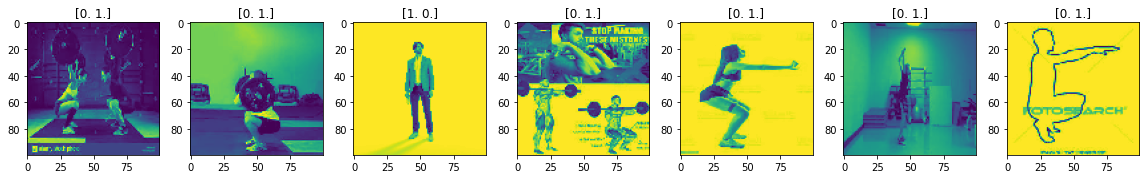

In [5]:
plt.figure(figsize=(20, 20))  # specifying the overall grid size

for i in range(7):
    plt.subplot(7, 7, i+1)
    plt.title(str(y_train[i]))
    plt.imshow(x_train[i])
plt.show()

In [6]:
model = keras.Sequential()

# model.add(keras.layers.Conv2D(512, (6,6),
# activation='relu', input_shape=input_shape))

model.add(layers.Conv2D(128, (6, 6),
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.Conv2D(256, (4, 4), activation='relu'))

model.add(layers.BatchNormalization(momentum=0.3))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))
model.add(layers.Dropout(0.7))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(output_shape, activation='softmax'))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 95, 128)       4736      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 256)       524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [7]:
batch_size = 32
epochs = 50
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
31/31 [==============================] - 8s 118ms/step - loss: 17.0428 - categorical_accuracy: 0.5073 - val_loss: 7.1638 - val_categorical_accuracy: 0.5830
Epoch 2/50
31/31 [==============================] - 3s 82ms/step - loss: 6.0489 - categorical_accuracy: 0.6250 - val_loss: 3.3492 - val_categorical_accuracy: 0.5951
Epoch 3/50
31/31 [==============================] - 3s 85ms/step - loss: 1.4645 - categorical_accuracy: 0.6435 - val_loss: 2.2545 - val_categorical_accuracy: 0.6073
Epoch 4/50
31/31 [==============================] - 3s 83ms/step - loss: 0.8001 - categorical_accuracy: 0.6111 - val_loss: 0.9886 - val_categorical_accuracy: 0.6518
Epoch 5/50
31/31 [==============================] - 3s 86ms/step - loss: 0.5764 - categorical_accuracy: 0.7104 - val_loss: 0.7905 - val_categorical_accuracy: 0.6842
Epoch 6/50
31/31 [==============================] - 3s 88ms/step - loss: 0.6152 - categorical_accuracy: 0.6996 - val_loss: 0.7105 - val_categorical_accuracy: 0.6964
Epoch 7/

Test loss: 0.9326268434524536
Test accuracy: 0.8340080976486206


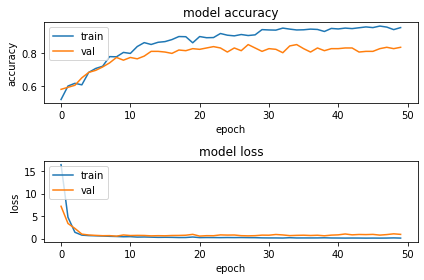

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

plt.figure(1)

# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

### Verify the predictions being made
---

17
24


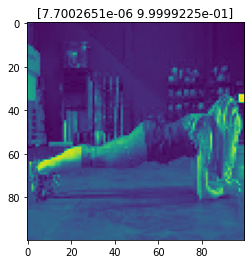

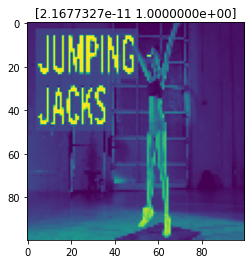

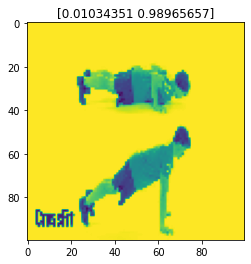

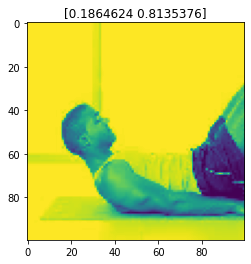

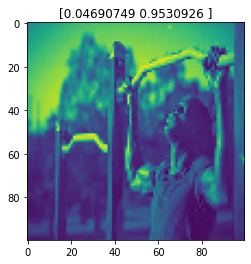

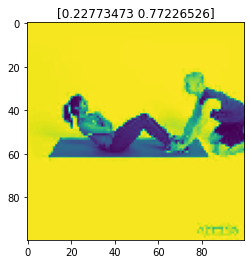

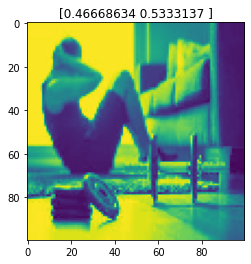

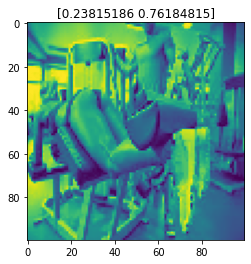

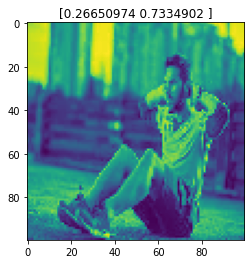

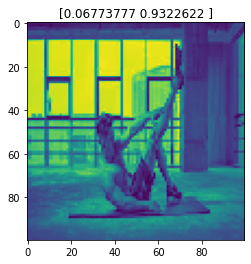

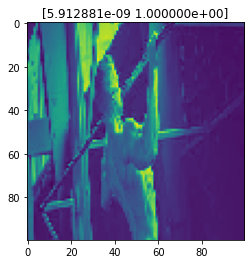

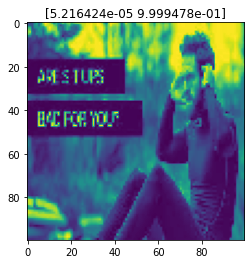

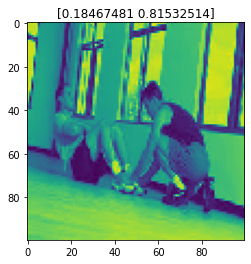

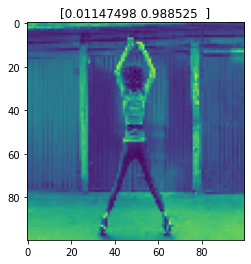

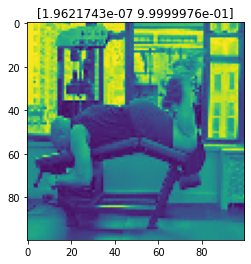

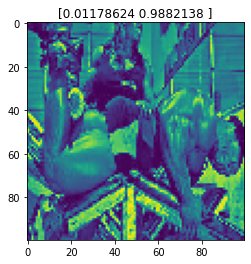

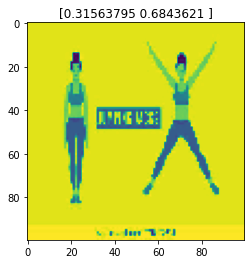

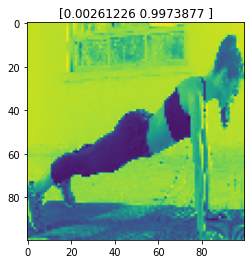

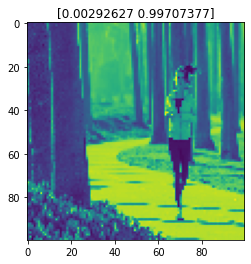

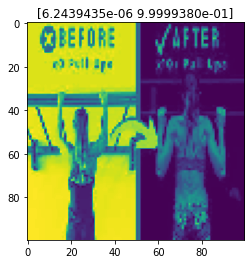

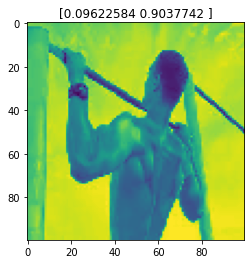

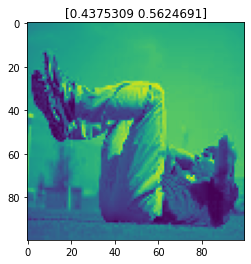

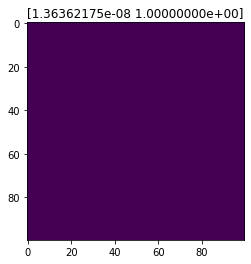

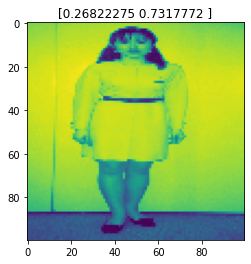

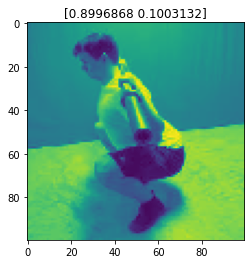

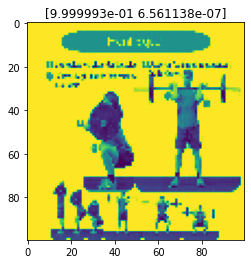

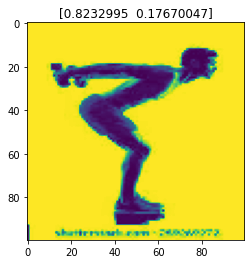

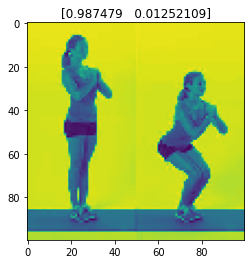

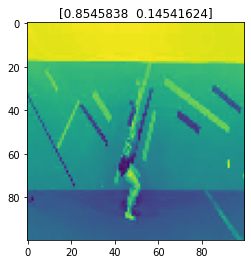

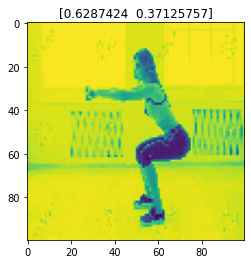

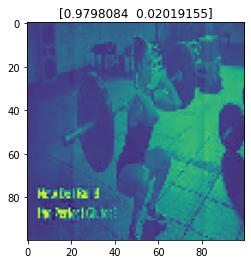

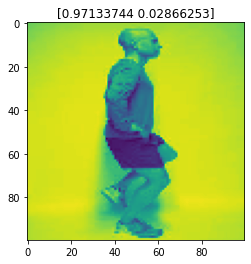

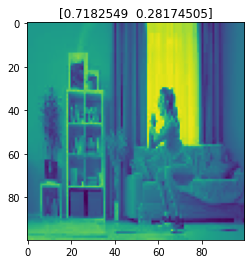

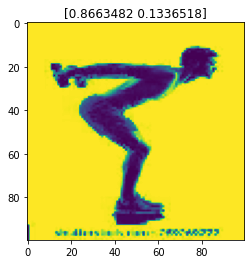

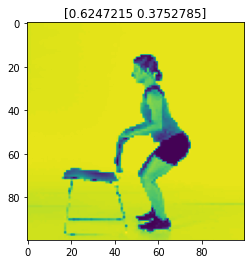

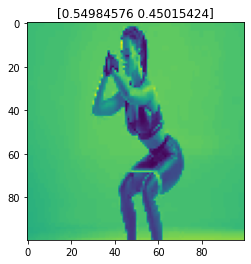

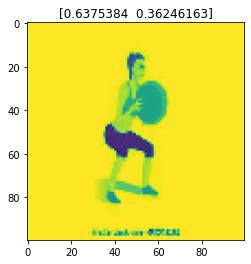

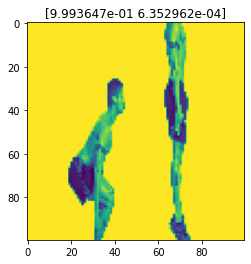

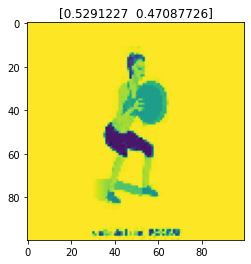

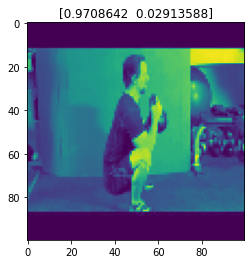

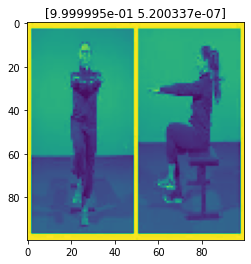

In [9]:
def decoder(one_pred):
    if one_pred[0] > one_pred[1]:
        return np.float32([1, 0])
    else:
        return [0, 1]


squat_preds = model.predict(x_test)
decoded = np.apply_along_axis(decoder, 1, squat_preds)

incorrect_squats = []
incorrect_non_squats = []

for i in range(len(y_test)):
    if (np.array_equal(decoded[i], y_test[i])) is False:
        if y_test[i][0] == 1:
            incorrect_non_squats.append(i)
        else:
            incorrect_squats.append(i)

print(len(incorrect_squats))
print(len(incorrect_non_squats))

for i in incorrect_non_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()

print()

for i in incorrect_squats:
    plt.imshow(image.array_to_img(x_test[i, :, :, :]))
    plt.title(str(squat_preds[i]))
    plt.show()
